In [2]:
# Import necessary modules
import torch 
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim


# Setting the transfomation pipeline each of the image has to go through
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize([0.5], [0.5])
                               ])

# Setting training set and testing set
trainset = datasets.FashionMNIST('~/.pytorch/Fashion-MNIST/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/Fashion-MNIST/', download=True, train=False, transform=transform)


# Defining iterators for training and testing data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle=True)


# Testing if the iterator is working
images, labels = next(iter(trainloader))
plt.imshow(images[9,:].view(28,28), cmap='gray')

In [6]:
#Define a model

model = nn.Sequential(nn.Linear(28*28,128), 
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64, 32),
                     nn.ReLU(), 
                     nn.Linear(32, 10), 
                     nn.LogSoftmax(dim=1))

# Define criterion. NLLLoss is a suitable criterion as the last layer in above model is logsoftmax
criterion= nn.NLLLoss()

# Defining the optimizer for training the network. SGD refers to stochastic gradient descent.
optimizer = optim.SGD(model.parameters(), lr = 0.003)

# Epochs refers to the numbers of iterations through the whole data
epochs = 5

train_losses = []
test_losses = []
accuracies = []

for e in range(epochs):
    # Training
    training_loss = 0
    test_loss = 0
    accuracy = 0
    for images, labels in trainloader:
        
        # Changing images inputs to 2d matrices with number of rows as number of images in each iteration and each row 
        # vector representing a flattened image
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        # Calculating the log softmax probabilities
        logps = model(images)
        
        # Calculating the loss
        loss = criterion(logps, labels)
        
        # Calculating the gradients
        loss.backward()
        
        # Updating the weights
        optimizer.step()
        
        # Updating the training loss
        training_loss += loss.item()
    else:
        # Testing
        
        # Making sure no gradient calculation happens in the testing step
        with torch.no_grad():
            for images, labels in testloader:
                
                # Read comments from the training loop
                images = images.view(images.shape[0], -1)
                logps = model(images)
                test_loss += criterion(logps, labels)
                
                
                # Calculating the probabilities from the log softmax probabilities
                ps = torch.exp(logps)
                
                # Finding the class with highest probability
                top_p, top_class = ps.topk(1, dim=1)
                
                # Checking if the prediction equals the actual label
                equality = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equality.type(torch.FloatTensor))
                
                
        # Updating the list of training, testing and accuracy with epochs
        train_losses.append(training_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracies.append(accuracy/len(testloader))
            
    print("Epoch number: {}".format(e+1),
         "Training loss: {}".format(train_losses[-1]),
          "Testing loss: {}".format(test_losses[-1]),
          "Accuracy: {}".format(accuracies[-1])
         )
        
        





Epoch number: 1 Training loss: 2.2297523898610683 Testing loss: 2.068737745285034 Accuracy: 0.3779856562614441
Epoch number: 2 Training loss: 1.532010305347219 Testing loss: 1.063965916633606 Accuracy: 0.6459991931915283
Epoch number: 3 Training loss: 0.8912905466709056 Testing loss: 0.7954716086387634 Accuracy: 0.7117834687232971
Epoch number: 4 Training loss: 0.7329751458694177 Testing loss: 0.707165539264679 Accuracy: 0.7384554147720337
Epoch number: 5 Training loss: 0.6576571928412676 Testing loss: 0.6480109691619873 Accuracy: 0.7664211988449097


Text(0.5, 1.0, 'Correct label : 3, Predicted label : 3')

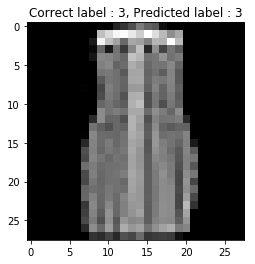

In [5]:
images, labels = next(iter(testloader))
idx = 5
image = images[idx]
with torch.no_grad():
    logps = model(images[idx].view(1, -1))
    ps = torch.exp(logps)

plt.imshow(image.view(28, 28), cmap='gray')        
plt.title("Correct label : " + str(labels[idx].item()) + ", Predicted label : "+ str(torch.argmax(ps).item()))